# ADNE - Task 1

- André Bastos, nº 56969
- Rafaela Cruz, nº 56926

Tensorflow version: 2.2.0

## Imports

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from shutil import copy

import IPython.display as display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Dense, Reshape
from tensorflow.keras.layers import MaxPooling2D, Activation, Flatten, Dropout, LeakyReLU

print(tf.__version__)

2.2.0


### Import data from Drive

In [0]:
from google.colab import drive
drive.mount('/content/google-drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/google-drive


## Copying tfrecords from drive to colab

In [0]:
!mkdir trainData
numbers_to_get = np.arange(0,40)
for number in numbers_to_get:
    name = "/content/google-drive/My Drive/ADNE/data/images_gray_" + str(number) + ".tfrecords"
    copy(name, "./trainData/")
!ls trainData

images_gray_0.tfrecords   images_gray_22.tfrecords  images_gray_35.tfrecords
images_gray_10.tfrecords  images_gray_23.tfrecords  images_gray_36.tfrecords
images_gray_11.tfrecords  images_gray_24.tfrecords  images_gray_37.tfrecords
images_gray_12.tfrecords  images_gray_25.tfrecords  images_gray_38.tfrecords
images_gray_13.tfrecords  images_gray_26.tfrecords  images_gray_39.tfrecords
images_gray_14.tfrecords  images_gray_27.tfrecords  images_gray_3.tfrecords
images_gray_15.tfrecords  images_gray_28.tfrecords  images_gray_4.tfrecords
images_gray_16.tfrecords  images_gray_29.tfrecords  images_gray_5.tfrecords
images_gray_17.tfrecords  images_gray_2.tfrecords   images_gray_6.tfrecords
images_gray_18.tfrecords  images_gray_30.tfrecords  images_gray_7.tfrecords
images_gray_19.tfrecords  images_gray_31.tfrecords  images_gray_8.tfrecords
images_gray_1.tfrecords   images_gray_32.tfrecords  images_gray_9.tfrecords
images_gray_20.tfrecords  images_gray_33.tfrecords
images_gray_21.tfrecords  images

## Create tfrecords dataset

We divided the tfrecord files into three different datasets, which are meant for training, validation and testing.
These sets were created using 75% of the total files for training, 12,5% for validation and 12,5% for testing.

In [0]:
tfrecordsDir = 'trainData/'
trainNumbers = np.arange(0,40)
trainfiles = [tfrecordsDir + 'images_gray_'+ str(i) + '.tfrecords' for i in trainNumbers]

train_raw_image_dataset = tf.data.TFRecordDataset(trainfiles[:30])
valid_raw_image_dataset = tf.data.TFRecordDataset(trainfiles[30:35])
test_raw_image_dataset = tf.data.TFRecordDataset(trainfiles[35:])

We checked how many examples are each set:

In [0]:
# Number of examples in training set
count =0
for i in train_raw_image_dataset:
    count +=1
print(count)

99990


In [0]:
# Number of examples in validation set
count =0
for i in valid_raw_image_dataset:
    count +=1
print(count)

16665


In [0]:
# Number of examples in test set
count =0
for i in test_raw_image_dataset:
    count +=1
print(count)

16665


## Decode tfrecords

In [0]:
# Create a dictionary describing the features.
image_feature_description = {
            'chinaprov': tf.io.FixedLenFeature([], tf.int64),
            'letter': tf.io.FixedLenFeature([], tf.int64),
            'seq0':  tf.io.FixedLenFeature([], tf.int64),
            'seq1': tf.io.FixedLenFeature([], tf.int64),
            'seq2':  tf.io.FixedLenFeature([], tf.int64),
            'seq3': tf.io.FixedLenFeature([], tf.int64),
            'seq4':  tf.io.FixedLenFeature([], tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
        }

In [0]:
def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

In [0]:
train_parsed_image_dataset = train_raw_image_dataset.map(_parse_image_function)
valid_parsed_image_dataset = valid_raw_image_dataset.map(_parse_image_function)
test_parsed_image_dataset = test_raw_image_dataset.map(_parse_image_function)

## Create inputs and labels from raw images

In [0]:
num_chinaprov = 38
num_letter = 38
num_seq = 38

def buildLabels(parsed_data):
    chinaprov = parsed_data['chinaprov']
    chinaprov_enc = tf.keras.backend.one_hot(chinaprov,num_chinaprov)
    letter = parsed_data['letter']
    letter_enc = tf.keras.backend.one_hot(letter, num_letter)
    seq0 = parsed_data['seq0']
    seq0_enc = tf.keras.backend.one_hot(seq0, num_seq)
    seq1 = parsed_data['seq1']
    seq1_enc = tf.keras.backend.one_hot(seq1, num_seq)
    seq2 = parsed_data['seq2']
    seq2_enc = tf.keras.backend.one_hot(seq2, num_seq)
    seq3 = parsed_data['seq3']
    seq3_enc = tf.keras.backend.one_hot(seq3, num_seq)
    seq4  = parsed_data['seq4']
    seq4_enc = tf.keras.backend.one_hot(seq4, num_seq)
    label = tf.stack([chinaprov_enc, letter_enc, seq0_enc, seq1_enc, seq2_enc, seq3_enc, seq4_enc])
    return label

def buildInputsLabels(parsed_data):
    img = tf.image.decode_png(parsed_data['image_raw'])
    img = tf.dtypes.cast(img, dtype = tf.float32)
    labels = buildLabels(parsed_data)   
    return   img,  labels

In [0]:
trainDataset = train_parsed_image_dataset.map(buildInputsLabels).shuffle(500)
validDataset = valid_parsed_image_dataset.map(buildInputsLabels).shuffle(500)
testDataset = test_parsed_image_dataset.map(buildInputsLabels)

## Convolutional Neural Network

Based on the detection module presented on the paper *Towards End-to-End License Plate Detection and Recognition: A Large Dataset and Baseline*, we created a convolutional neural network to identify the license plate characters and numbers in our dataset. We made some changes to the original network, using 6 convolutional layers with increasing number of neurons and varying strides. In every layer, we used Leaky ReLU as activation function, batch normalization, Max Pooling and a dropout of 0.1. In the end, we used a dense layer with 7 * 38 neurons.

In [0]:
def create_cnn_model():

    inputs = Input(shape=(580,360,1))

    layer = Conv2D(112, (5,5), strides=2, padding="same", input_shape=(580,360,1))(inputs)
    layer = Activation(LeakyReLU())(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)
    layer = Dropout(0.1)(layer)

    layer = Conv2D(128, (5,5), strides=2, padding="same")(layer)
    layer = Activation(LeakyReLU())(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = MaxPooling2D(pool_size=(2,2), strides=1)(layer)
    layer = Dropout(0.1)(layer)

    layer = Conv2D(192, (5,5), strides=2, padding="same")(layer)
    layer = Activation(LeakyReLU())(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)
    layer = Dropout(0.1)(layer)

    layer = Conv2D(224, (5,5), strides=2, padding="same")(layer)
    layer = Activation(LeakyReLU())(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = MaxPooling2D(pool_size=(2,2), strides=1)(layer)
    layer = Dropout(0.1)(layer)

    layer = Conv2D(256, (5,5), strides=1, padding="same")(layer)
    layer = Activation(LeakyReLU())(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = MaxPooling2D(pool_size=(2,2), strides=2)(layer)
    layer = Dropout(0.1)(layer)

    layer = Conv2D(256, (3,3), strides=1, padding="same")(layer)
    layer = Activation(LeakyReLU())(layer)
    layer = BatchNormalization(axis=-1)(layer)
    layer = MaxPooling2D(pool_size=(2,2), strides=1)(layer)
    layer = Dropout(0.1)(layer)

    layer = Flatten()(layer)
    layer = Dense(7*38)(layer)
    layer = Reshape((7,38))(layer)

    model = Model(inputs = inputs, outputs = layer)
  
    return model

### Necessary functions

In [0]:
# Function that trains a model and returns it alongside with the history
def train(train_dataset, validation_dataset):

    model = create_cnn_model()
    model.summary()

    opt = tf.keras.optimizers.Adam(lr=0.001)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer = opt,
                  loss = loss, 
                  metrics = ["accuracy"])

    history = model.fit(train_dataset.batch(16), epochs=15, 
                      validation_data=validation_dataset.batch(16))

    return model, history
  
# Function that predicts the outputs of a given model using a given input tensor
# Inputs must be an array/tensor in the format (?,580,360,1) and outputs another with format (?,7)
def predict(model, inputs):

    predicted = model.predict(inputs, batch_size = 16)

    # Revert one-hot encoding
    labels_predicted = []
    for pred in predicted:
        softmax = tf.nn.softmax(pred, axis = 1)
        labels_predicted.append(np.argmax(softmax, axis = 1))

    return labels_predicted

# Function that retuns the test error based on the given model and dataset
def evaluate(model, eval_dataset):
    test_error = model.evaluate(eval_dataset.batch(16))
    return test_error

# Plot results on a graphic
def plot_errors(train_errors, val_errors):
    f, ax = plt.subplots(1)
    ax.plot(train_errors,'b',label='Training')
    ax.plot(val_errors,'r',label='Validation')
    ax.legend()
    plt.show(f)

### Create and train the model and evaluate the results

In [0]:
# Create and train the model
model, history = train(trainDataset, validDataset)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 580, 360, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 290, 180, 112)     2912      
_________________________________________________________________
activation (Activation)      (None, 290, 180, 112)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 290, 180, 112)     448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 145, 90, 112)      0         
_________________________________________________________________
dropout (Dropout)            (None, 145, 90, 112)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 45, 128)       358528

In [0]:
# Compute loss and accuracy on test set
test_error = evaluate(model, testDataset)
print(f"test_error: {test_error}")

1042/1042 [==============================] - 31s 30ms/step - loss: 0.2028 - accuracy: 0.9437
test_error: [0.20277199149131775, 0.9436886310577393]


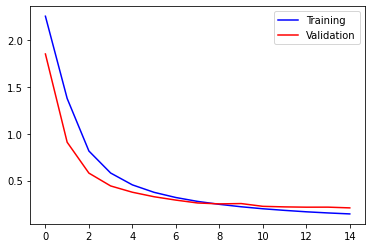

In [0]:
# Plot the loss for training and validation sets during training
history_dict = history.history
train_error = history_dict['loss']
val_error = history_dict['val_loss']
plot_errors(train_error, val_error)

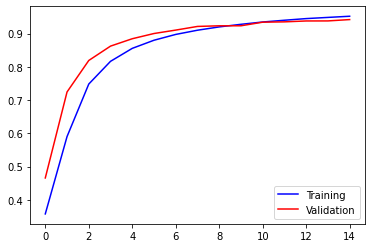

In [0]:
# Plot the accuracy for training and validation sets during training
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plot_errors(train_acc, val_acc)

Predict the labels for one example in the test set:

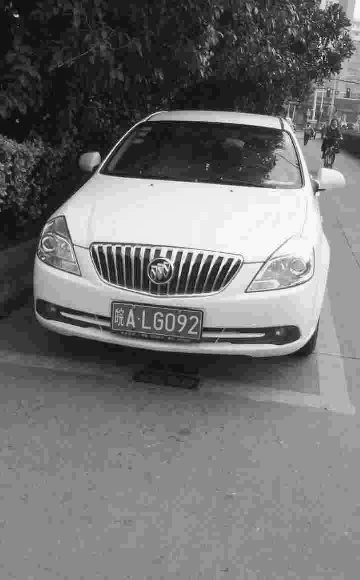

(580, 360, 1)


In [0]:
# Show the image for the example
it = iter(test_parsed_image_dataset)
data_parsed = next(it)
image = data_parsed['image_raw'].numpy()
display.display(display.Image(data=image))
img = tf.image.decode_png(data_parsed['image_raw'])
print(img.numpy().shape)

In [0]:
# Compare the true labels with the predictions for that example
firstIt = iter(testDataset)
data =next(firstIt)

label = data[1]
softmax = tf.nn.softmax(label, axis = 1)
label = np.argmax(softmax, axis = 1)
print("True label:", label)

test_inputs = [data[0].numpy()]
test_inputs = tf.convert_to_tensor(test_inputs, dtype=tf.float32)
prediction = predict(model,test_inputs)
print("Prediction:", prediction)

True label: [ 0  0 10  6 24 33 26]
Prediction: [array([ 0,  0, 10,  6, 24, 33, 26])]
